This notebook uses sensitivity analysis results to produce *global* stability plots i.e., violin plots in the main paper. 

In [18]:
import os
import copy
import re 

import numpy as np

from epimodel import preprocess_data

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

%matplotlib inline

In [19]:
data = preprocess_data('../merged_data/data_final_nov.csv', last_day='2020-05-30', smoothing=1)
data.mask_reopenings(print_out = False)

Dropping NPI Mask Wearing
Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [20]:
results_base_dir = "../server_final_nov2/"

def tag_fname_to_label(tag, fname):    
    if tag == "cases_threshold":
        r = re.search(r"(cases_t)(\d*)", fname)
        return r.groups()[1]
    
    if tag == "deaths_threshold":
        r = re.search(r"(deaths_t)(\d*)", fname)
        return r.groups()[1]
    
    if tag == "scalings":
        if "simple" in fname:
            return "Random Constant Scaling"
        else:
            return "Time-Varying Correction"
    
    if tag == "npi_leaveout":
        npi_names = data.CMs
        r = re.search(r"(\d*)", fname)[0]
        label = f"{npi_names[int(r[0])]}"
        for npi in r[1:]:
            label += f",\n{npi_names[int(npi)]}"
            
        return label
    
    if tag == "growth_noise":
        npi_names = data.CMs
        r = re.search(r"(growth_noise)-(\d*.\d*)", fname)
        
        return r.groups()[1]
    
    if tag == "iceswe":
        return "Iceland and Sweden Excluded"
            
    if tag == "NPI_prior":
        if "icl" in fname:
            return "Flaxman et. al."
        
        if "half_normal" in fname:
            return "$\\alpha_i \sim$Half Normal$(0.2^2)$"
        
        if "normal" in fname and "0.2" in fname:
            return "$\\alpha_i \sim$Normal$(0, 0.2^2)$"
        
        if "normal" in fname and "10" in fname:
            return "$\\alpha_i \sim$Normal$(0, 10^2)$"
        
    if tag == "oxcgrt":
        npi_names = ['Mask Wearing', 'Travel Screen/Quarantine', 'Travel Bans', 'Public Transport Limited',
                          'Internal Movement Limited', 'Public Information Campaigns', 'Symptomatic Testing']
        r = re.search(r"(\d*)", fname)[0]
        label = f"{npi_names[int(r[0])]}"
        for npi in r[1:]:
            label += f",\n{npi_names[int(npi)]}"
        return label
            
    if tag == "R_prior":
        r = re.search(r"(R_prior-)(\d*.\d*)", fname)
        val = r.groups()[1]
        return val
    
    if tag == "alpha_noise_Scale":
        r = re.search(r"(alpha_noise-)(\d*.\d*)", fname)
        val = r.groups()[1]
        return val

    if tag == "region_holdout":
        return fname[:2]
    
    if tag == "structural":
        if "default" in fname:
            return "Fixed Effects"
        
        if "additive" in fname:
            return "Additive"
        
        if "cases" in fname:
            return "Only Case Data"
        
        if "deaths" in fname:
            return "Only Death Data"
        
        if "noisy" in fname:
            return "Noisy-R (Fixed Effects)"
        
        if "discrete_renewal_fixed_gi" in fname:
            return "Discrete Renewal$^*$"
        
    if tag == "alpha_noise_scale":
        an = re.search(r"(alpha_noise-)(\d*.\d*)", fname).groups()[1]
        print(an)
        return an

        
    return f"{tag} - {fname}"

def load_tagged_traces(result_base_dir, tag, extension='-cs.txt'):
    path = os.path.join(results_base_dir, tag)
    
    all_traces = []
    for filedir, _, files in os.walk(path):
        for f in files:
            if extension in f and 'CasesDelay' not in f and 'DeathsDeath' not in f and '_GI_' not in f:
                try:
                    trace = np.loadtxt(os.path.join(filedir, f))
                    all_traces.append([trace, tag_fname_to_label(tag, f)])
                except Exception as e:
                    print(e)
                    
    return all_traces

def search_tagged_traces(result_base_dir, tag, search_key, extension='-cs.txt'):
    path = os.path.join(results_base_dir, tag)
    
    for filedir, _, files in os.walk(path):
        for f in files:
            if extension in f and search_key in f:
                    trace = np.loadtxt(os.path.join(filedir, f))
                    label =  tag_fname_to_label(tag, f)
                    return (trace, label)
    
    print('No experiment found')
    return None

In [21]:
# notes - ignore additive model
categories = ['npi_leaveout', 'cases_threshold', 'deaths_threshold', 'region_holdout', 'oxcgrt', 'epiparam_prior', 'R_prior', 'npi_prior', 'structural_mean', 'scaling', 'alpha_noise_scale']

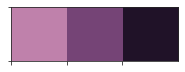

In [22]:
derived_features = [
 ("Gatherings limited to\n1000 people or less", [0]),
 ("Gatherings limited to\n100 people or less", [1, 0]),
 ("Gatherings limited to\n10 people or less", [2, 1, 0]),
 ("Some businesses\nclosed", [3]),
 ("Most nonessential\nbusinesses closed", [4, 3]),
 ("Schools and universities\nclosed", [5, 6]),
 ("Stay-at-home order\n(with exemptions)", [7]),  
 ]

fp2 = FontProperties(fname=r"../../fonts/Font Awesome 5 Free-Solid-900.otf")

cols = sns.cubehelix_palette(3, start=0.2, light=0.6, dark=0.1, rot=0.2)
sns.palplot(cols)

cm_plot_style = [
            ("\uf0c0", cols[0]), # ppl
            ("\uf0c0", cols[1]), # ppl
            ("\uf0c0", cols[2]), # ppl
            ("\uf07a", cols[0]), # shop 1
            ("\uf07a", cols[2]), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]

In [23]:
def combine_trace(trace, derived_features):
    nS, _ = trace.shape
    nCMs = len(derived_features)
    derived_samples = np.zeros((nS, nCMs))

    for f_i, (f, prodrows) in enumerate(derived_features):
        samples = np.ones(nS)
        for r in prodrows:
            samples = samples * trace[:, r] 
        derived_samples[:, f_i] = samples

    res = copy.deepcopy(derived_samples)
    res = 100*(1-res)
    
    return res

In [24]:
def bucket_npis_medians(l, u, medians):
    nCMs = len(derived_features)
    # low, medium, high
    bucket_array = np.zeros((nCMs, 3), dtype=np.float64)
    
    nT, nCM = medians.shape
    for t in range(nT):    
        for i in range(nCMs):
            median = medians[t, i]
            if median > u:
                bucket_array[i, 2] += 1
            elif median > l:
                bucket_array[i, 1] += 1
            elif not np.isnan(median):
                # just neglect the nans
                bucket_array[i, 0] += 1
            
    return bucket_array

# numerics

In [25]:
loaded_dict = {}
nCMs = len(derived_features)

for c_i, c in enumerate(categories):
    ts = load_tagged_traces(results_base_dir, c)
    rts, labels = zip(*ts)
    
    if c == 'npi_leaveout':
        for l_i, label in enumerate(labels):
            for cm_i, cm in enumerate(data.CMs):
                if cm in label and '<' not in cm:
                    rts[l_i][:, cm_i] = np.nan
                elif cm == label:
                    rts[l_i][:, cm_i] = np.nan
    
    if c == 'oxcgrt':
        for l_i, label in enumerate(labels):
            if label in ['Symptomatic Testing', 'Mask Wearing']:
                temp = copy.deepcopy(rts[l_i])
                rts[l_i][:, :8] = temp[:, 1:9]
                
    if c == 'scalings':
        rts = [np.exp(-t) for t in rts]
    
    medians = np.zeros((0, nCMs))
    
    for t in rts:
        comb_t = np.median(combine_trace(t, derived_features), axis=0).reshape((1, nCMs))
        medians = np.append(comb_t, medians, axis=0)
        
    loaded_dict[c] = medians

0.02
0.03
0.05


# violin plots

In [26]:
import pandas as pd

In [27]:
def categories_to_df(cats):
    xs = []
    ys = []

    for c in cats:
        dt = loaded_dict[c]
        nT, _ = dt.shape
        for t in range(nT):
            for cm in range(nCMs):
                if not np.isnan(dt[t, cm]):
                    xs.append(dt[t, cm])
                    ys.append(derived_features[cm][0])

    df = pd.DataFrame.from_dict({'npi': ys, 'med': xs})
    return df

In [28]:
def violin_plot(l, u, data):
    plt.plot([0, 0], [-1, 10], color=cols[2], linestyle='--', alpha=0.75, zorder=-5, linewidth=0.75)
    plt.plot([l, l], [-1, 10], color=cols[2], linestyle='--', alpha=0.75, zorder=-5, linewidth=0.75)
    plt.plot([u, u], [-1, 10], color=cols[2], linestyle='--', alpha=0.75, zorder=-5, linewidth=0.75)

   
    sns.stripplot(x="med", y="npi", data=data, color=[0.37647059, 0.37647059, 0.37647059, 1.], order=[l for l, _ in derived_features], size=3.5, zorder=-4, jitter=False)
    sns.violinplot(x="med", y="npi", data=data, scale='width', color=cols[0], saturation=1, order=[l for l, _ in derived_features],
                  cut=0, inner='box');
        
    x_min = -10
    x_max = 60
    plt.xlim([x_min, x_max])
    xtick_vals = [0, 17.5, 35, 52.5] 
    xtick_str = [f"{x:.1f}%" for x in xtick_vals]
    plt.ylim([6.5, -0.5])

    x_r = np.abs(x_min - x_max)
    for cm in range(nCMs):
        for i, val in enumerate(derived_features[cm][1]):
            if val < len(cm_plot_style):
                col = cm_plot_style[val][1]
            else:
                col = "k"
            plt.text(x_min - 4.5 - 6*i, cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                         fontproperties=fp2, fontsize=10, color=col)

    ax = plt.gca()
    plt.yticks(np.arange(nCMs), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
    yax = ax.get_yaxis()
    yax.set_tick_params(pad=120)

    for i, (ticklabel, tickloc) in enumerate(zip(ax.get_yticklabels(), ax.get_yticks())):
        if i < len(cm_plot_style):
                col = cm_plot_style[i][1]
        else:
            col = "k"
        ticklabel.set_color(col)

    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlabel("Median reduction in $R_t$", fontsize=8)
    plt.ylabel(None)
    
def small_violin_plot(l, u, data, xlabel=True):
    plt.plot([0, 0], [-1, 10], color=cols[2], linestyle='--', alpha=0.75, zorder=-5, linewidth=0.75)
    plt.plot([l, l], [-1, 10], color=cols[2], linestyle='--', alpha=0.75, zorder=-5, linewidth=0.75)
    plt.plot([u, u], [-1, 10], color=cols[2], linestyle='--', alpha=0.75, zorder=-5, linewidth=0.75)
    
    sns.stripplot(x="med", y="npi", data=data, color=[0.37647059, 0.37647059, 0.37647059, 1.], order=[l for l, _ in derived_features], size=2, zorder=-4, jitter=False)
    sns.violinplot(x="med", y="npi", data=data, scale='width', color=cols[0], saturation=1, order=[l for l, _ in derived_features],
                   linewidth=0.5, inner=None, cut=0)
    x_min = -10
    x_max = 60
    plt.xlim([x_min, x_max])
    xtick_vals = [0, 17.5, 35, 52.5] if xlabel is not False else []
    xtick_str = [f"{x:.1f}%" for x in xtick_vals] if xlabel is not False else []
    plt.ylim([7.5, -0.5])

    x_r = np.abs(x_min - x_max)
    for cm in range(nCMs):
        for i, val in enumerate(derived_features[cm][1]):
            if val < len(cm_plot_style):
                col = cm_plot_style[val][1]
            else:
                col = "k"
            plt.text(x_min - 6.5 - 8.5*i, cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                         fontproperties=fp2, fontsize=7, color=col)

    ax = plt.gca()
    
    for i, (ticklabel, tickloc) in enumerate(zip(ax.get_yticklabels(), ax.get_yticks())):
        if i < len(cm_plot_style):
                col = cm_plot_style[i][1]
        else:
            col = "k"
        ticklabel.set_color(col)
    
    plt.xticks(xtick_vals, xtick_str, fontsize=6)
    plt.xlabel("Median reduction in $R_t$" if xlabel else None, fontsize=7)
    plt.ylabel(None)
    plt.yticks([])
    
def scatter_plot(l, u, data, xlabel=True):
    plt.plot([0, 0], [-1, 10], color=cols[2], linestyle='--', alpha=0.75, zorder=-5, linewidth=0.75)
    plt.plot([l, l], [-1, 10], color=cols[2], linestyle='--', alpha=0.75, zorder=-5, linewidth=0.75)
    plt.plot([u, u], [-1, 10], color=cols[2], linestyle='--', alpha=0.75, zorder=-5, linewidth=0.75)
    
    sns.swarmplot(data['med'], data['npi'], color=cols[0], size=3)
#     sns.violinplot(x="med", y="npi", data=data, scale='width', color=cols[0], saturation=1, order=[l for l, _ in derived_features],
#                    linewidth=0.5, inner=None)
    x_min = -10
    x_max = 60
    plt.xlim([x_min, x_max])
    xtick_vals = [0, 17.5, 35, 52.5] if xlabel is not False else []
    xtick_str = [f"{x:.1f}%" for x in xtick_vals] if xlabel is not False else []
    plt.ylim([6.5, -0.5])

    x_r = np.abs(x_min - x_max)
    for cm in range(nCMs):
        for i, val in enumerate(derived_features[cm][1]):
            if val < len(cm_plot_style):
                col = cm_plot_style[val][1]
            else:
                col = "k"
            plt.text(x_min - 6.5 - 8.5*i, cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                         fontproperties=fp2, fontsize=7, color=col)

    ax = plt.gca()
    
    for i, (ticklabel, tickloc) in enumerate(zip(ax.get_yticklabels(), ax.get_yticks())):
        if i < len(cm_plot_style):
                col = cm_plot_style[i][1]
        else:
            col = "k"
        ticklabel.set_color(col)
    
    plt.xticks(xtick_vals, xtick_str, fontsize=6)
    plt.xlabel("Median reduction in $R_t$" if xlabel else None, fontsize=7)
    plt.ylabel(None)
    plt.yticks([])

In [29]:
len(categories)

11

In [30]:
# npi_leaveout: 7+1
# cases_threshold: 5
# deaths_threshold: 4
# region_holdout: 41
# oxcgrt: 6
# epiparam_prior: 125
# R_prior: 4
# npi_prior: 3
# structural_mean: 5
# scaling: 2
# alpha_noise_scale: 4

'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


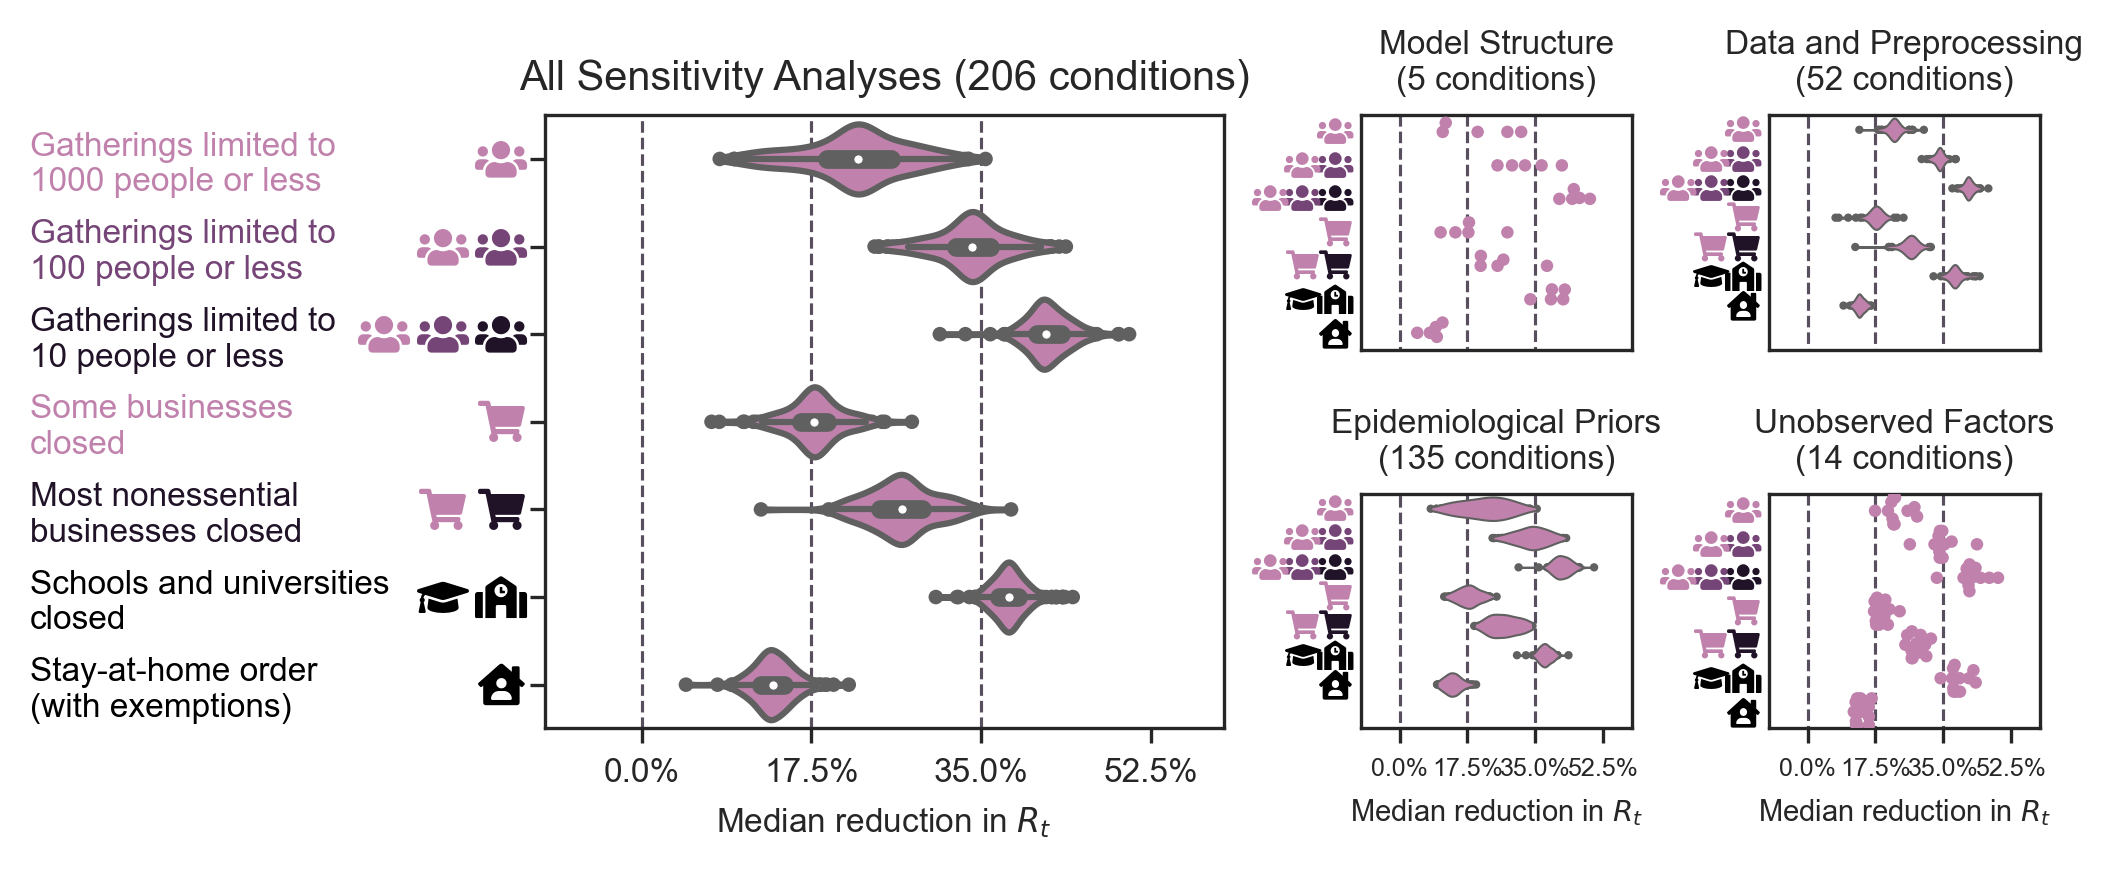

In [31]:
l = 17.5
u = 35

fig = plt.figure(figsize=(7, 3), dpi=300)
gs = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(gs[:, :2])
data_all = categories_to_df(categories)
violin_plot(l, u, data_all)
plt.title('All Sensitivity Analyses (206 conditions)', fontsize=10)

ax2 = fig.add_subplot(gs[0, 2])
data_subpanel = categories_to_df(['structural_mean'])
scatter_plot(l, u, data_subpanel, False)
plt.title('Model Structure\n(5 conditions)', fontsize=8)

ax3 = fig.add_subplot(gs[0, 3])
data_subpanel = categories_to_df(['region_holdout', 'cases_threshold', 'deaths_threshold'])
small_violin_plot(l, u, data_subpanel, False)
plt.title('Data and Preprocessing\n(52 conditions)', fontsize=8)

ax4 = fig.add_subplot(gs[1, 2])
data_subpanel = categories_to_df(['epiparam_prior', 'R_prior', 'npi_prior'])
small_violin_plot(l, u, data_subpanel)
plt.title('Epidemiological Priors\n(135 conditions)', fontsize=8)

ax5 = fig.add_subplot(gs[1, 3])
data_subpanel = categories_to_df(['oxcgrt', 'npi_leaveout'])
scatter_plot(l, u, data_subpanel)
plt.title('Unobserved Factors\n(14 conditions)', fontsize=8)

plt.tight_layout(w_pad=-0)
plt.savefig(f'figs/violins.pdf', bbox_inches='tight')

# bucket plots

In [32]:
def bucket_array_plot(bucket_array, title, ylabel=True):
    bucket_array_p = 100*bucket_array / np.sum(bucket_array, axis=1)[:, None]
    im = plt.imshow(bucket_array_p, cmap='inferno', aspect='auto')
    
    for cm in range(nCMs):
        amax = np.argmax(bucket_array_p[cm, :])
        plt.text(amax, cm, f'{int(bucket_array_p[cm, amax]):d}%', ha='center', va='center')
        
        for j in range(3):
            if j != amax:
                plt.text(j, cm, f'{int(np.round(bucket_array_p[cm, j])):d}%', ha='center', va='center', color='white')

    for cm in range(nCMs):
        for i, val in enumerate(derived_features[cm][1]):
            if val < len(cm_plot_style):
                col = cm_plot_style[val][1]
            else:
                col = "k"
            plt.text(-0.7 - 0.25*i, cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                         fontproperties=fp2, fontsize=12, color=col)

    ax = plt.gca()
    if ylabel:
        plt.yticks(np.arange(nCMs), [f"{f[0]}" for f in derived_features], fontsize=10, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=165)

    for i, (ticklabel, tickloc) in enumerate(zip(ax.get_yticklabels(), ax.get_yticks())):
        if i < len(cm_plot_style):
                col = cm_plot_style[i][1]
        else:
            col = "k"
        ticklabel.set_color(col)

    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top') 
#     plt.xlabel(f'NPI Effectiveness')
    plt.xticks([0, 1, 2], ["Low", "Medium", "High"], fontsize=10)
    plt.title(title, fontsize=12)
    
#     ax = plt.gca()
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     cbr = plt.colorbar(im, cax=cax, format=PercentFormatter())
#     ax = plt.gca()
#     ax.tick_params(axis="both", which="major", labelsize=10)
#     cbr.set_ticks([0, 25, 50, 75, 100])
    
    
def bucket_array_plot_small(bucket_array, title):
    bucket_array_p = 100*bucket_array / np.sum(bucket_array, axis=1)[:, None]
    im = plt.imshow(bucket_array_p, cmap='inferno', aspect='auto')
    
    for cm in range(nCMs):
        for i in range(3):
            amax = np.argmax(bucket_array_p[cm, :])
        plt.text(amax, cm, f'{int(bucket_array_p[cm, amax]):d}%', ha='center', va='center', fontsize=7)
        
        for j in range(3):
            if j != amax:
                plt.text(j, cm, f'{int(np.round(bucket_array_p[cm, j])):d}%', ha='center', va='center', color='white', fontsize=7)
        
    plt.yticks(np.arange(nCMs), [])
    for cm in range(nCMs):
        for i, val in enumerate(derived_features[cm][1]):
            if val < len(cm_plot_style):
                col = cm_plot_style[val][1]
            else:
                col = "k"
            plt.text(-0.8 - 0.3*i, cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                         fontproperties=fp2, fontsize=8, color=col)

    ax = plt.gca()

    for i, (ticklabel, tickloc) in enumerate(zip(ax.get_yticklabels(), ax.get_yticks())):
        if i < len(cm_plot_style):
                col = cm_plot_style[i][1]
        else:
            col = "k"
        ticklabel.set_color(col)

    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top') 
    plt.xticks([0, 1, 2], ["Low", "Medium", "High"], fontsize=6)
    plt.title(title, fontsize=8)
    
#     ax = plt.gca()
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     cbr = plt.colorbar(im, cax=cax, format=PercentFormatter())
#     ax = plt.gca()
#     ax.tick_params(axis="both", which="major", labelsize=6)
#     cbr.set_ticks([0, 25, 50, 75, 100])

npi_leaveout: 7
cases_threshold: 5
deaths_threshold: 4
region_holdout: 41
oxcgrt: 6
epiparam_prior: 125
R_prior: 4
npi_prior: 3
structural_mean: 5
scaling: 2
alpha_noise_scale: 3


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


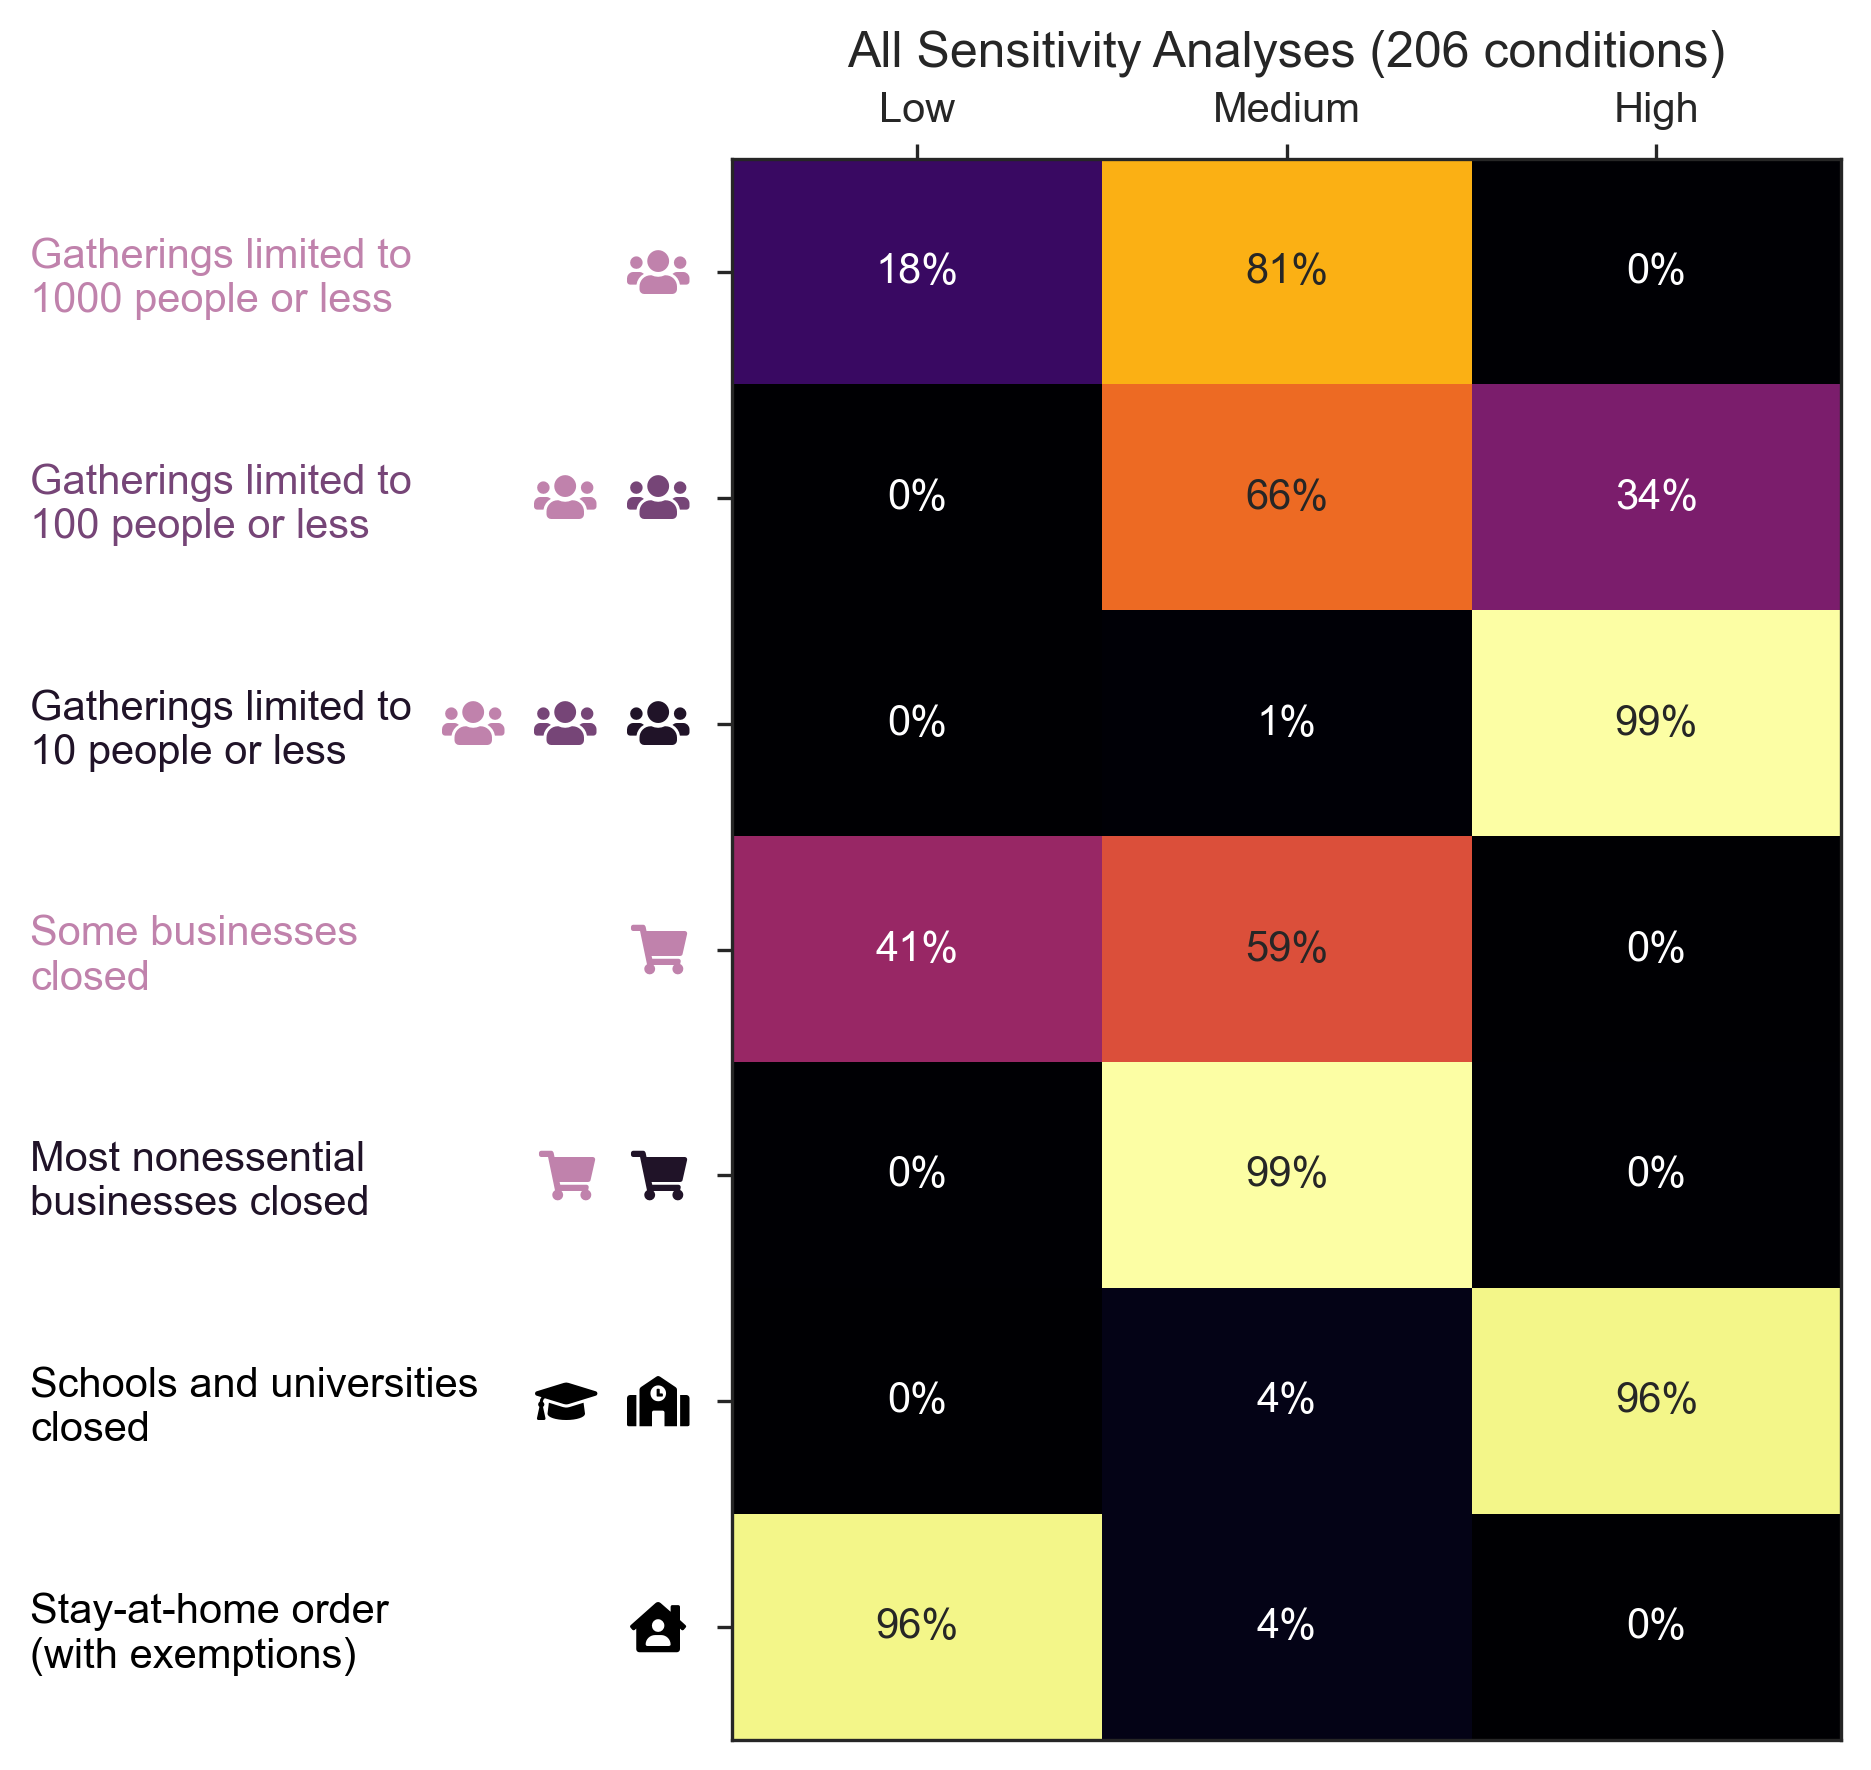

In [33]:
l = 17.5
u = 35


bucket_dict = {}
for c_i, c in enumerate(categories):
    bucket_array = bucket_npis_medians(l, u, loaded_dict[c])
    n = int(np.sum(bucket_array, axis=1)[0])
    print(f'{c}: {n}')
    bucket_dict[c] = bucket_array

fig = plt.figure(figsize=(10, 6), dpi=300)

nCMs = len(derived_features)

gs = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(gs[:, :2])

ba = np.zeros((nCMs, 3))
for _, ba_c in bucket_dict.items():
    ba += ba_c

n = int(np.sum(ba, axis=1)[0])
bucket_array_plot(ba, f'All Sensitivity Analyses ({n+1} conditions)')
plt.tight_layout(w_pad=-0.25)
plt.savefig(f'figs/buckets_{l}_{u}.pdf', bbox_inches='tight')